<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/graph_based_prefiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nome:** Bruno Francisco Rodrigues Mafra, **RA:** 11201811147

**Nome:** Beatriz Sofientini Ribeiro, **RA:** 11202020433

**Nome:** Felipe Fernandes Gomes da Silva Costa, **RA:** 11202020223

\\
___

##**Tema: Método avançado de filtragem de metadados baseado em grafos para melhorar a busca por similaridade vetorial em aplicações RAG**

Otimizando a busca por similaridade vetorial com técnicas baseadas em grafos usando LangChain e Neo4j.

\\
___
\\
Embeddings de texto nos ajudam a encontrar documentos se baseando em similaridade semântica, entendendo seus significados e quão semelhantes eles são entre si. Porém, eles nem sempre são eficientes para filtrar informações específicas, como datas ou categorias. Por exemplo, se você precisa encontrar documentos de um ano específico ou de uma categoria específica como "Ficção Científica", os embeddings podem não dar conta sozinhos ou as vezes fornecem resultados não muito precisos, daí surge a necessidade de filtragem de metadados, permitindo restringir resultados com base em atríbutos específicos.

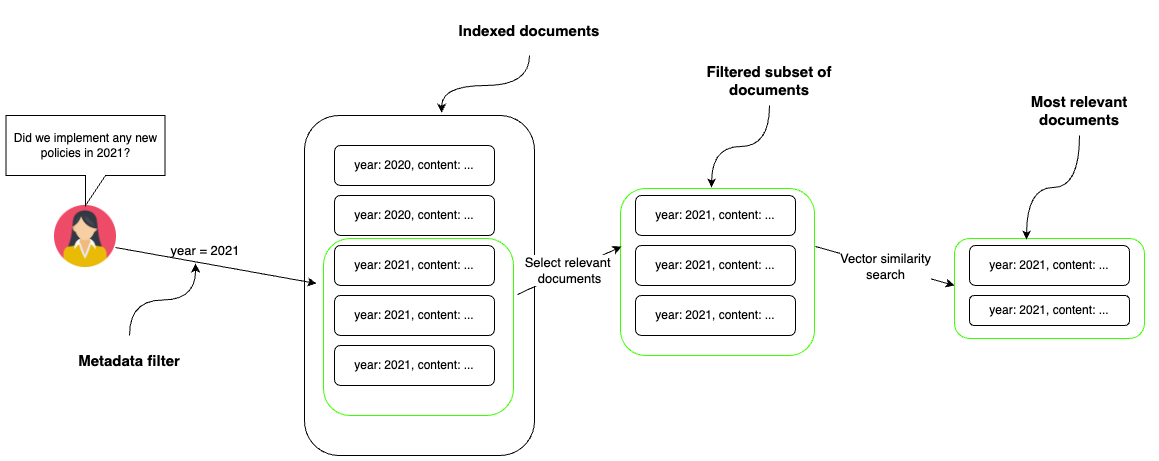


Na imagem fornecida, o processo começa com o usuário perguntando se alguma nova política foi implementada em 2021. A abordagem de pré-filtragem é então usada, nela você primeiro seleciona os documentos relevantes, nesse caso aqueles que são do ano de 2021, e depois aplica a busca por similaridade vetorial no conjunto de documentos escolhidos. Esse processo de apenas duas etapas aumenta a acurácia e a relevância dos resultados da busca.

Já existe hoje suporte via LangChain para [filtragem de metadados no Neo4j](https://python.langchain.com/docs/integrations/vectorstores/neo4jvector/#metadata-filtering) baseado na propriedade de nós, porém bancos de dados em grafos podem armazenar dados estruturados e interligados de forma muito complexa, e nesses casos as formas de filtragem existentes podem ser limitadas.

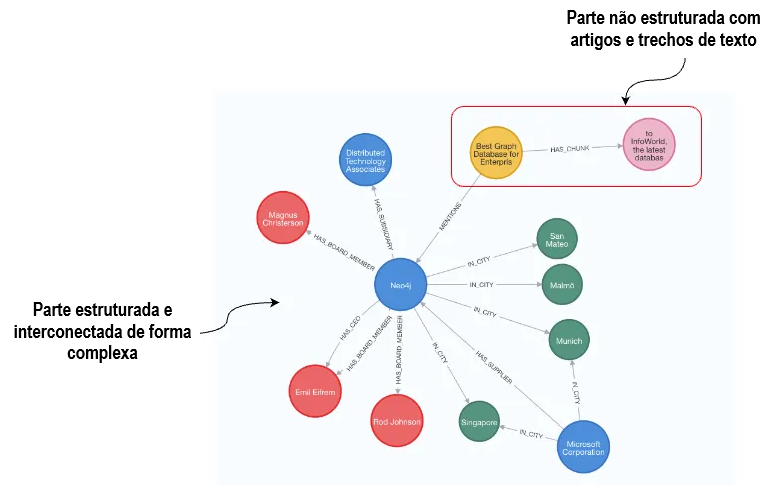

Em um banco de dados em grafos como o da imagem acima, os dados podem estar divididios entre estruturados e não estruturados. A parte não estruturada do conjunto de dados representa os nós com artigos e seus trechos de texto. Esses nós por sua vez estão conectados com outros nós que contém mais informações sobre o artigo, como a data, sentimento, autor, etc., (parte estruturada).

No exemplo acima, os artigos estão ligados às organizações que mencionam, nesse caso o artigo menciona o Neo4j. Esse conjunto de dados inclui uma grande quantidade de informações estruturadas sobre o Neo4j, como seus investidores, membros do conselho, fornecedores, e mais.

Assim, podemos aproveitar a vasta quantidade de informação estruturada para executar uma filtragem sofisticada de metadado e refinar precisamente a seleção de artigos usando critérios estruturados, como os da seguinte pergunta:

- *Existem notícias **negativas** sobre empresas nas quais o **Neo4j** investiu em **2024**?*


\\
___
## **O que faremos?**
Usaremos o mesmo dataset do exemplo acima chamado "companies", disponível em um servidor de demonstração público hospedado pelo Neo4j e iremos implementar um agente da OpenAI com uma única ferramenta, que pode gerar dinamicamente instruções Cypher (linguagem de consulta do Neo4j) com base na entrada do usuário e recuperar artigos relevantes do banco de dados de grafos.

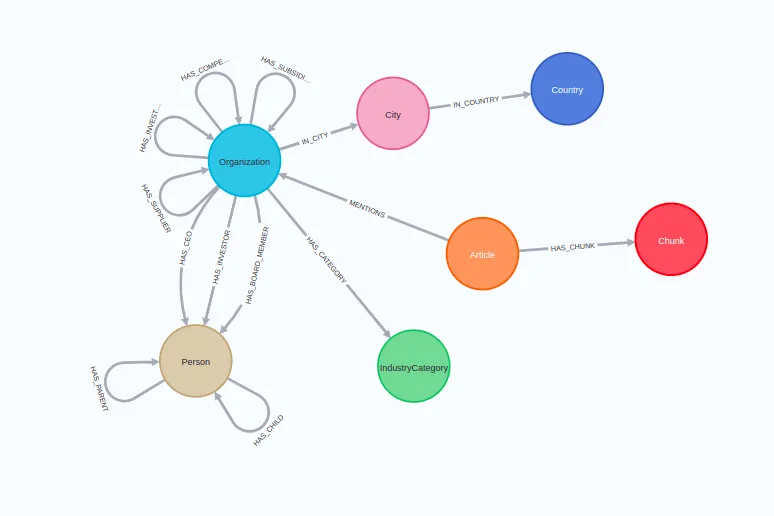

(Grafo do schema completo do banco)

Neste exemplo, a ferramenta terá quatro parâmetros de entrada opcionais:

- **Tópico (topic)**: Qualquer informação ou tópico específico, além de organização, país e sentimento, no qual o usuário está interessado.

- **Empresa (organization)**: A organização sobre a qual o usuário deseja encontrar informações.

- **País (country)**: O país das organizações nas quais o usuário está interessado.

- **Sentimento (sentiment)**: O sentimento dos artigos.

Usaremos a resposta obtida pela consulta ao banco para recuperar informações relevantes do grafo e usá-las como contexto para gerar a resposta final utilizando um modelo de linguagem (LLM).


\\
___
# **Implementação do código**
O primeiro passo é importar as bibliotecas essências, definir credenciais e estabelecer conexão com o banco Neo4j.

In [2]:
!pip install --quiet langchain langchain-community langchain-openai neo4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.5/373.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/4

In [3]:
import os
from typing import Dict, List, Optional, Tuple, Type #Imports para adicionar tipagem

#Imports do langchain para OpenAI, RAG, Tools, etc
from langchain.agents import AgentExecutor
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser
from langchain.callbacks.manager import CallbackManagerForToolRun
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.tools import BaseTool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#Imports relacionados ao Neo4J
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars

In [4]:
import os
from getpass import getpass

# Adicionar key da OpenAI ao executar essa célula
os.environ["OPENAI_API_KEY"] = getpass()

# Informações para acessar o banco de dados no Neo4j
# Como é somente um banco para demonstração, as senhas e dados de acesso podem ficar públicas
os.environ["NEO4J_URI"] = "neo4j+s://demo.neo4jlabs.com"
os.environ["NEO4J_USERNAME"] = "companies"
os.environ["NEO4J_PASSWORD"] = "companies"
os.environ["NEO4J_DATABASE"] = "companies"

··········


In [6]:
embeddings = OpenAIEmbeddings() # Configura um sistema para gerar embeddings no formato da OpenAI
graph = Neo4jGraph() # Inicia conexão com o bancos de dados Neo4j

# Aqui são gerados os embeddings a partir artigos existentes no banco Neo4j
# Ou seja, os textos são transformados em vetores númericos com base no modelo da OpenAI
vector_index = Neo4jVector.from_existing_index(
    embeddings,
    index_name="news"
)

\\
___

## Implementação das funções utilizadas

Essas são as funções principais e auxiliares que serão utilizadas pelo agente.

In [7]:
# Esta função gera uma consulta em Cypher chamada de "full-text search query" a partir de uma string de entrada.
# Ela é útil para lidar com buscas que podem incluir erros ortográficos, permitindo maior flexibilidade e precisão ao mapear o nomes das empresas a partir da entrada do usuário.
def generate_full_text_query(input: str) -> str:
    # Remove caracteres especiais da entrada, e quebra a string em palavras.
    # Cada palavra recebe um operador de similaridade e são or fim concatenada com um operador AND
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

# Query em Cypher para realizar uma busca sobre os nós do tipo "Organization"
candidate_query = """
CALL db.index.fulltext.queryNodes($index, $fulltextQuery, {limit: $limit})
YIELD node
WHERE node:Organization // Filter organization nodes
RETURN distinct node.name AS candidate
"""

# Essa função retornas o nome de até 5 empresas que podem corresponder a string de entrada fornecida pelo usuário
def get_candidates(input: str, limit: int = 5) -> List[Dict[str, str]]:
    # Obtém a query necessária a partir da função definida anteriormente
    ft_query = generate_full_text_query(input)

    # Executa a query no banco usando "candidate_query" e "ft_query"
    candidates = graph.query(
        candidate_query, {"fulltextQuery": ft_query, "index": 'entity', "limit": limit}
    )

    # Se houver um match idêntico retorne ele
    direct_match = [el["candidate"] for el in candidates if el["candidate"].lower() == input.lower()]
    if direct_match:
        return direct_match

    # Caso contrário retorna a lista com as sugestões possíveis
    return [el["candidate"] for el in candidates]

In [8]:
# Exemplo de uso da função get_candidates

get_candidates("neo4")

['Net4', 'Neo4j', 'Neos', 'Neo', 'Neon Software']

In [9]:
# O artigo como um todo gira em torno da função a seguir que é responsável por criar dinamicamente uma consulta em Cypher para retornar somente informação relevante do banco de dados.

def get_organization_news(
    topic: Optional[str] = None,
    organization: Optional[str] = None,
    country: Optional[str] = None,
    sentiment: Optional[str] = None,
) -> str:
    # Se não existir pré-processamento, podemos usar somente a busca por similaridade vetorial
    if topic and not organization and not country and not sentiment:
        return vector_index.similarity_search(topic)

    # Define o início da query com uso de processamento em paralelo quando possível
    base_query = (
        "CYPHER runtime = parallel parallelRuntimeSupport=all "
        "MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE "
    )

    # Vetor de strings para armazenar todas as cláusulas WHERE adicionais
    where_queries = []

    # Cria um objeto para guardar os parâmetros que serão usados na query
    params = {"k": 5} # Parâmetro k define o número máximo de artigos que devem ser retornados

    # Quando o parâmetro organization (nome da empresa) existir:
    if organization:
        # A partir do nome fornecido pelo usuário, buscar por possíveis candidatos no banco
        candidates = get_candidates(organization)

        if len(candidates) > 1:  # Se mais de um for encontrado, perguntar pro usuário qual ele deseja
            return (
                "Ask a follow up question which of the available organizations "
                f"did the user mean. Available options: {candidates}"
            )

        # Uma vez encontrado o match ideal, adicionar uma cláusula WHERE na query para só retornar artigos sobre essa empresa
        where_queries.append(
            "EXISTS {(a)-[:MENTIONS]->(:Organization {name: $organization})}"
        )
        params["organization"] = candidates[0]

    # Quando o parâmetro country (país) existir:
    if country:
        # Adicionar uma cláusula WHERE na query para só retornar artigos sobre esse país
        where_queries.append(
            "EXISTS {(a)-[:MENTIONS]->(:Organization)-[:IN_CITY]->()-[:IN_COUNTRY]->(:Country {name: $country})}"
        )
        params["country"] = country

    # Quando o parâmetro sentiment (sentimento) existir adiciona uma claúsula WHERE pata retornar só artigos com o mesmo sentimento
    if sentiment:
        if sentiment == "positive":
            where_queries.append("a.sentiment > $sentiment")
            params["sentiment"] = 0.5
        else:
            where_queries.append("a.sentiment < $sentiment")
            params["sentiment"] = -0.5

    # Se houver o parâmetro tópico usar a busca por similaridade para retornar somente artigos sobre o mesmo tópico
    if topic:
        vector_snippet = (
            " WITH c, a, vector.similarity.cosine(c.embedding,$embedding) AS score "
            "ORDER BY score DESC LIMIT toInteger($k) "
        )
        params["embedding"] = embeddings.embed_query(topic)
        params["topic"] = topic
    else:  # Caso contrário simplesmente retornar os k artigos mais recentes
        vector_snippet = " WITH c, a ORDER BY a.date DESC LIMIT toInteger($k) "

    # Formatação da saída
    return_snippet = "RETURN '#title ' + a.title + '\n#date ' + toString(a.date) + '\n#text ' + c.text AS output"

    # Concatena todas as cláusulas WHERE que foram criadas usando um AND
    complete_query = (
        base_query + " AND ".join(where_queries) + vector_snippet + return_snippet
    )

    # Executa a query no banco e printa a query montada
    data = graph.query(complete_query, params)
    print(f"Cypher: {complete_query}\n")

    # Printa os parâmetros utilizados (sem os embeddings)
    params.pop('embedding', None)
    print(f"Parameters: {params}")

    # Por fim, retorna os artigos
    return "###Article: ".join([el["output"] for el in data])

In [10]:
# Exemplo de uso da função get_organization_news

get_organization_news(
    organization='neo4j',
    sentiment='positive',
    topic='remote work'
)

Cypher: CYPHER runtime = parallel parallelRuntimeSupport=all MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE EXISTS {(a)-[:MENTIONS]->(:Organization {name: $organization})} AND a.sentiment > $sentiment WITH c, a, vector.similarity.cosine(c.embedding,$embedding) AS score ORDER BY score DESC LIMIT toInteger($k) RETURN '#title ' + a.title + '
#date ' + toString(a.date) + '
#text ' + c.text AS output

Parameters: {'k': 5, 'organization': 'Neo4j', 'sentiment': 0.5, 'topic': 'remote work'}


'#title Accounts in Transit: Ruder Finn Adds Neo4j\n#date 2023-04-27T00:00:00Z\n#text Ruder Finn signs on as North American agency of record for Neo4j, a native graph database and analytics company. The agency will be responsible for implementing an integrated communications program, as well as working to amplify awareness of the company and category. The scope of work will include strategic media relations and executive communications to support corporate and product PR. Antonia Caamaño, SVP of RF Tech, will lead the Ruder Finn team handling the account out of New York. "We chose Ruder Finn to achieve our next stage of awareness because of the agency\'s experience in enterprise IT and deep tech, which allows them to deliver smart strategies and creative executions, as well as their long-running relationships with top-tier media,” said Neo4j CMO Chandra Rangan.\nOak Public Relations is named communications agency of record for Custom Cones USA, which produces supplies for cannabis pre-

\\
___
## Criando uma ferramenta e definindo um agente da OpenAI

Por fim, precisamos transformar a função em uma ferramenta que possa ser usada por um Agente que interage com um modelo da OpenAI.

In [11]:
# Exemplos de como o LLM deve tratar o input para a maneira correta de identificar um tópico
fewshot_examples = """{Input:What are the health benefits for Google employees in the news? Topic: Health benefits}
{Input: What is the latest positive news about Google? Topic: None}
{Input: Are there any news about VertexAI regarding Google? Topic: VertexAI}
{Input: Are there any news about new products regarding Google? Topic: new products}
"""

# Essa classe estabelece os parâmetros esperados para a ferramenta NewsTool, que será definida logo abaixo.
class NewsInput(BaseModel):
    topic: Optional[str] = Field(
        description="Any particular topic that the user wants to finds information for. Here are some examples: "
        + fewshot_examples
    )
    organization: Optional[str] = Field(
        description="Organization that the user wants to find information about"
    )
    country: Optional[str] = Field(
        description="Country of organizations that the user is interested in. Use full names like United States of America and France."
    ) # Aqui é definido para o LLM como o nome do país deve ser formatado. Exemplo: USA viraria "United States of America"

    sentiment: Optional[str] = Field(
        description="Sentiment of articles", enum=["positive", "negative"]
    ) # Aqui é definido para o LLM que o parâmetro "sentiment" deve ser uma string escrito somente "positive" ou "negative"

In [12]:
# Essa classe representa uma ferramenta customizada que pode ser usada pelo agente
class NewsTool(BaseTool):
    name = "NewsInformation"
    description = (
        "useful for when you need to find relevant information in the news"
    ) # Essa descrição fornece informações para o LLM de quando é que ele deve usar essa ferramenta
    args_schema: Type[BaseModel] = NewsInput  # Define o esquema de argumentos que a ferramenta aceita, que é baseado na classe NewsInput.

    def _run(
        self,
        topic: Optional[str] = None,
        organization: Optional[str] = None,
        country: Optional[str] = None,
        sentiment: Optional[str] = None,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool."""
        return get_organization_news(topic, organization, country, sentiment)

    # Também pode ser executada de forma assincrona quando possível, para otimização
    async def _arun(
        self,
        topic: Optional[str] = None,
        organization: Optional[str] = None,
        country: Optional[str] = None,
        sentiment: Optional[str] = None,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool asynchronously."""
        return get_organization_news(topic, organization, country, sentiment)

In [13]:
# O criador do artigo optou por usar um modelo da OpenAI baseado em chat, mas outros tipos também seriam possíveis
llm = ChatOpenAI(temperature=0, model="gpt-4-turbo", streaming=True)

# Vetor com as ferramentas que serão fornecidas para o modelo, nesse caso só uma
tools = [NewsTool()]

# Faz um bind para que o modelo possa usar as tools fornecidas
llm_with_tools = llm.bind(functions=[convert_to_openai_function(t) for t in tools])


# Define um template para as interações do agente, especificando como as mensagens devem ser formatadas e apresentadas
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that finds information about movies "
            " and recommends them. If tools require follow up questions, "
            "make sure to ask the user for clarification. Make sure to include any "
            "available options that need to be clarified in the follow up questions "
            "Do only the things the user specifically requested. ",
        ), # Esses prompt apresenta instruções sobre o papel do agente
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# Esse template foi criado para ser usado em um ChatBot, por isso ele adiciona alguns componentes a mais como marcadores de histórico de conversa, mas não faremos uso dsso
def _format_chat_history(chat_history: List[Tuple[str, str]]):
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer


# Configura o agente combinando as entradas do usuário, o histórico de conversas, o rascunho do agente e a integração com as ferramentas.
agent = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: _format_chat_history(x["chat_history"])
        if x.get("chat_history")
        else [],
        "agent_scratchpad": lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIFunctionsAgentOutputParser()
)

# Finalmente, cria um executor que gerencia a execução do agente usando as ferramentas definidas
agent_executor = AgentExecutor(agent=agent, tools=tools)

\\
___
## Testando a implementação

Vamos rodar alguns inputs e examinar as saídas e obtidas juntamente com as querys que foram criadas pela pré-filtragem.

In [31]:
# Esse é um exemplo onde nenhum tópico é passado, nesse caso ele retorna somente os 5 artigos mais recentes que mencionam a empresa Neo4j

result = agent_executor.invoke({"input": "What are some positive news regarding neo4j?"})

print('\n**Input:**\n')
print(result['input'])

print('\n**Output:**\n')
print(result['output'])

Cypher: CYPHER runtime = parallel parallelRuntimeSupport=all MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE EXISTS {(a)-[:MENTIONS]->(:Organization {name: $organization})} AND a.sentiment > $sentiment WITH c, a ORDER BY a.date DESC LIMIT toInteger($k) RETURN '#title ' + a.title + '
#date ' + toString(a.date) + '
#text ' + c.text AS output

Parameters: {'k': 5, 'organization': 'Neo4j', 'sentiment': 0.5}

**Input:**

What are some positive news regarding neo4j?

**Output:**

Here are some positive news regarding Neo4j:

1. **New Product Integrations with Generative AI Features in Google Cloud Vertex AI**:
   - Neo4j has announced a new product integration with Google Cloud's latest generative AI features in Vertex AI. This integration allows enterprise customers to harness knowledge graphs built on Neo4j's fully managed cloud offerings in Google Cloud Platform for generative AI insights and recommendations that are more accurate, transparent, and explainable. This partnership empowers e

In [30]:
# Nesse exemplo o tópico fornecido foi usado para a busca por similaridade e, com base na query final, podemos ver que o agente fez uso da pré-filtragem para obter somente artigos com sentimento negativo.

result = agent_executor.invoke({"input": "What are some of the latest negative news about employee happiness for companies from France?"})

print('\n**Input:**\n')
print(result['input'])

print('\n**Output:**\n')
print(result['output'])

Cypher: CYPHER runtime = parallel parallelRuntimeSupport=all MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE EXISTS {(a)-[:MENTIONS]->(:Organization)-[:IN_CITY]->()-[:IN_COUNTRY]->(:Country {name: $country})} AND a.sentiment < $sentiment WITH c, a, vector.similarity.cosine(c.embedding,$embedding) AS score ORDER BY score DESC LIMIT toInteger($k) RETURN '#title ' + a.title + '
#date ' + toString(a.date) + '
#text ' + c.text AS output

Parameters: {'k': 5, 'country': 'France', 'sentiment': -0.5, 'topic': 'employee happiness'}

**Input:**

What are some of the latest negative news about employee happiness for companies from France?

**Output:**

Here are some of the latest negative news related to employee happiness for companies from France:

1. **IBM Whistleblower Case**: IBM has been ordered to pay £22,000 in compensation and two years' salary to a British employee who blew the whistle on unlawful working practices within the company. The employee faced retaliation from managers after r